In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt


In [3]:
WIN = 'D:/'
MAC = '/Volumes/Transcend2/17_20_PhD/19_20_PhD_Metabolomics/'

osp = MAC

### GP sampling 

Define several kernels from GPy.

In [4]:
import GPy
k_lin = GPy.kern.Linear(1)
k_exp = GPy.kern.Exponential(1)

k_rbf = GPy.kern.RBF(input_dim=1, variance=2.25, lengthscale=1.5)
k_mat32 = GPy.kern.Matern32(input_dim=1, variance=2., lengthscale=0.2)
k_mat52 = GPy.kern.Matern52(1)

k_per = GPy.kern.StdPeriodic(1, period=3.)
k_cos = GPy.kern.Cosine(1)
k_brwn = GPy.kern.Brownian(1)
k_nn = GPy.kern.MLP(1)

Make a vector with various kernels and calculate composite kernel.

In [5]:
ks = [k_lin, k_exp, k_rbf, k_nn, k_cos, k_rbf+k_nn, k_rbf*k_nn, k_rbf+k_cos]
ks_names = ['Linear', 'Exponential', 'RBF', 'MLP', 'Cosine', 'RBF+MLP', 'RBF*MLP','RBF+Cosine']

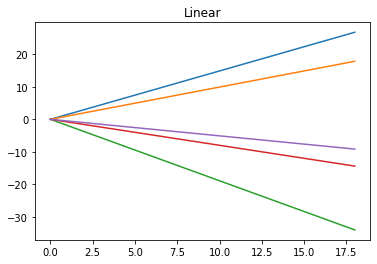

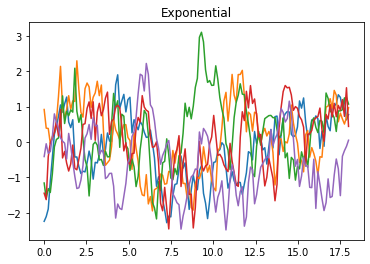

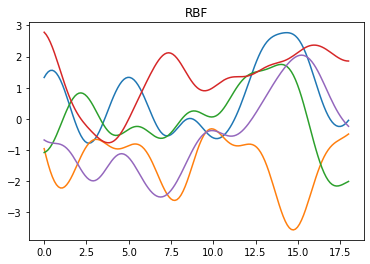

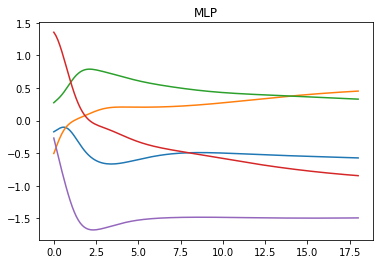

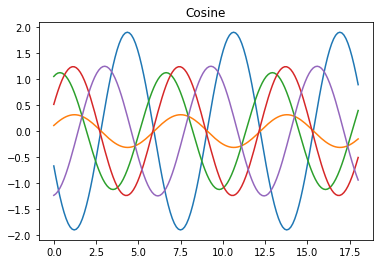

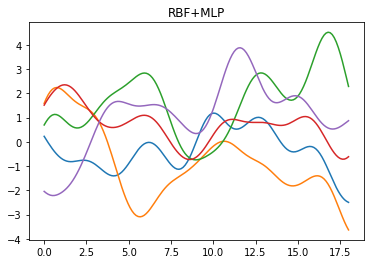

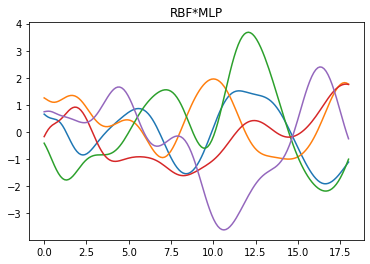

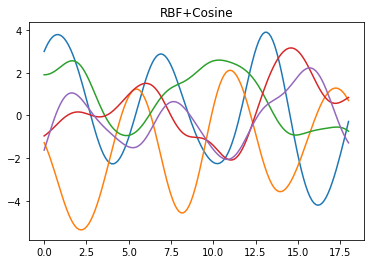

In [6]:
for k, name in zip(ks,ks_names):
    #sample from the kernel
    sample_space = np.linspace(0,18,150)[:,None]
    mu = np.zeros((150))
    C = k.K(sample_space)
        
    # Sample 5 times from a multivariate Gaussian distribution with mean 0 and covariance k(X,X)
    Z  = np.random.multivariate_normal(mu, C, 5)
    for i in range(5):
        plt.plot(sample_space, Z[i])
    plt.title(name)
    plt.show()

### GP regression for the RTs

Load the dictionary of matching standards.

In [7]:
with open(osp+'pymz/mzmine/std_matches.txt', 'rb') as file:
    matches = pickle.load(file)

#### Zika RT vs Malaria RT

In [8]:
from metab_utils import get_rts_between_datasets
mal_1_rt, zik_1_rt, mal1_zik1_diff = get_rts_between_datasets('mal', 'zik', matches)

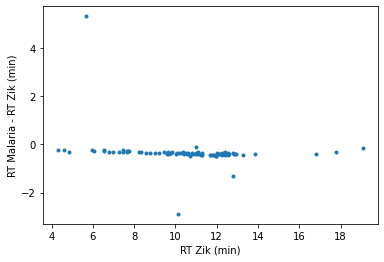

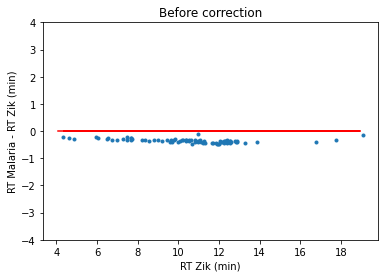

In [9]:
from metab_utils import plot_and_get_values_for_regression
zik_1_rt_mod, mal_1_rt_mod = plot_and_get_values_for_regression(zik_1_rt,'Zik',mal_1_rt,'Malaria',  mal1_zik1_diff, ml = False, zscore = 1.4)

Trying different type of kernels for the GP regression. At the end, the one with the highest cross-predicted accuracy is displayed.

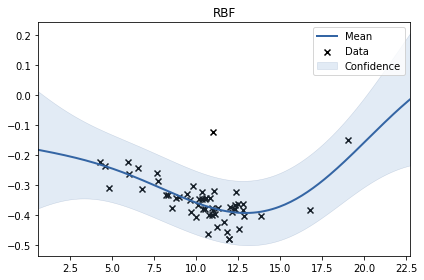

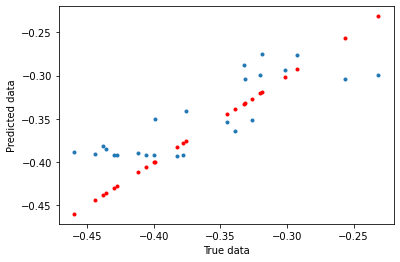

Cross-Predicted Accuracy for RBF : 0.6066407673472534
Mean absolute error for RBF : 0.03302864355301608
Mean squared error for RBF : 0.001450471240255831


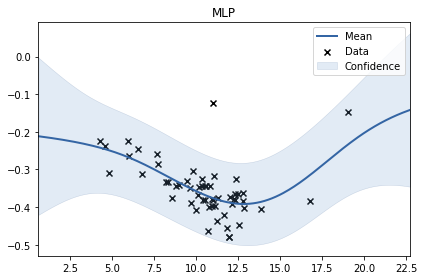

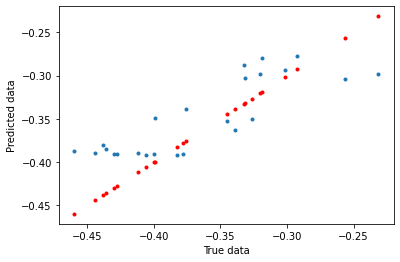

Cross-Predicted Accuracy for MLP : 0.6053469493724892
Mean absolute error for MLP : 0.032969656591166054
Mean squared error for MLP : 0.0014552420594123195


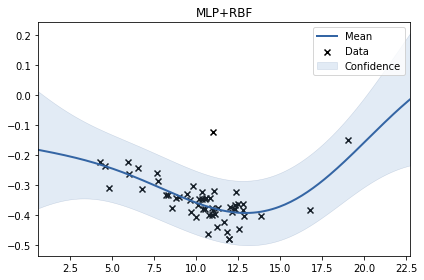

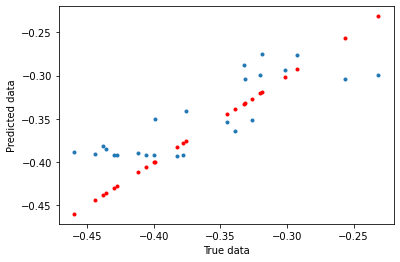

Cross-Predicted Accuracy for MLP+RBF : 0.6066417451034354
Mean absolute error for MLP+RBF : 0.033028618432062784
Mean squared error for MLP+RBF : 0.0014504676348816483


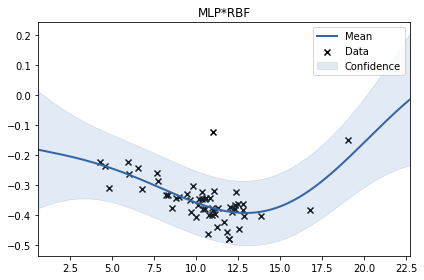

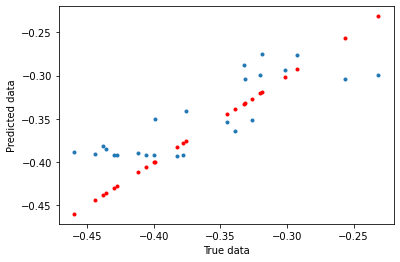

Cross-Predicted Accuracy for MLP*RBF : 0.6066308567876924
Mean absolute error for MLP*RBF : 0.033028882957632864
Mean squared error for MLP*RBF : 0.0014505077844129903


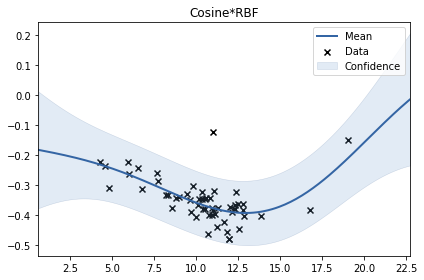

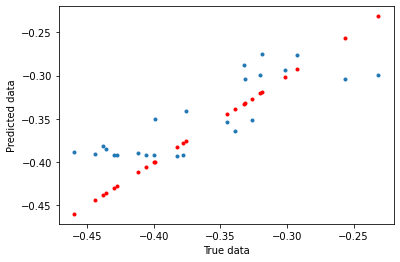

Cross-Predicted Accuracy for Cosine*RBF : 0.6066330352659657
Mean absolute error for Cosine*RBF : 0.033028889841823394
Mean squared error for Cosine*RBF : 0.0014504997515010342


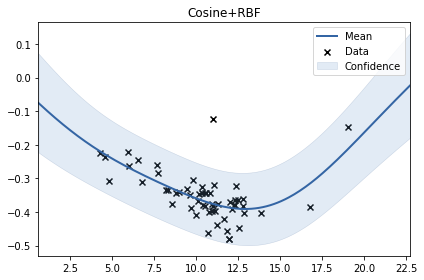

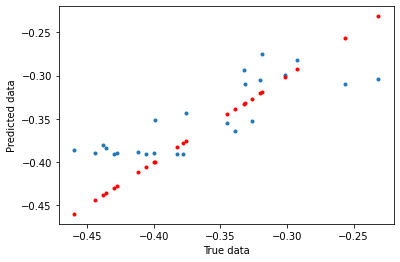

Cross-Predicted Accuracy for Cosine+RBF : 0.5959990842703607
Mean absolute error for Cosine+RBF : 0.032741985852041355
Mean squared error for Cosine+RBF : 0.001489711339304367
MLP+RBF


In [10]:
from metab_utils import try_gp_regressions
mmal, kmal, resultsmal = try_gp_regressions(mal_1_rt_mod, zik_1_rt_mod-mal_1_rt_mod)

In the end, we are using the RBF kernel for the GP regression.

rbf.,value,constraints,priors
variance,0.07137455873390168,+ve,
lengthscale,7.61386311937561,+ve,


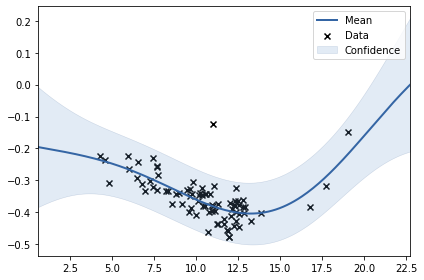

In [11]:
#kmal = kmal
kmal = GPy.kern.RBF(input_dim=1, variance=0.1, lengthscale=6.5)
mmal = GPy.models.GPRegression(np.array(mal_1_rt_mod)[:,None], np.array(zik_1_rt_mod)[:,None] - np.array(mal_1_rt_mod)[:,None],kmal)
#mmal.optimize_restarts(10)
mmal.optimize()
mmal.plot()
plt.ylim()

mmal.parameters[0]

(-1.0, 1.0)

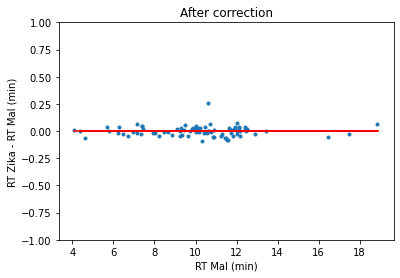

In [12]:
gpr_predicted_data,_ = mmal.predict(np.array(mal_1_rt_mod)[:,None])

plt.plot(np.array(mal_1_rt_mod)[:,None]+gpr_predicted_data, np.array(zik_1_rt_mod)[:,None] - (np.array(mal_1_rt_mod)[:,None]+gpr_predicted_data), '.')
plt.plot(np.array(zik_1_rt_mod)[:,None], np.array(zik_1_rt_mod)[:,None] -np.array(zik_1_rt_mod)[:,None], 'r')
plt.plot()
plt.xlabel('RT Mal (min)')
plt.ylabel('RT Zika - RT Mal (min)')
plt.title('After correction')
plt.ylim(-1,1)

Dumping the model with pickle for future use of the data.

In [13]:
with open('/Users/anamaria/Documents/pymz/mzmine/malmodel.txt', 'wb') as handle:
    pickle.dump(mmal, handle)

The same workflow will be applied for the analysis of the VL vs Zika RT datsets.

#### Zika RT vs VL RT 

In [13]:
from metab_utils import get_rts_between_datasets
vl_1_rt, zik_1_rt, vl1_zik1_diff = get_rts_between_datasets('vl', 'zik', matches)

In [14]:
len(vl_1_rt)

81

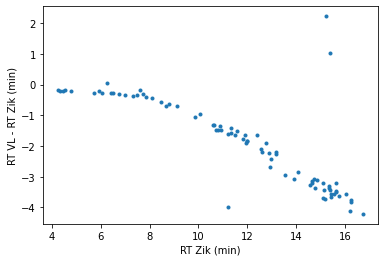

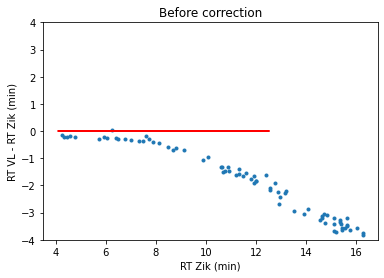

In [15]:
from metab_utils import plot_and_get_values_for_regression
zik_1_rt_mod, vl_1_rt_mod = plot_and_get_values_for_regression(zik_1_rt,'Zik',vl_1_rt,'VL', vl1_zik1_diff, ml = False)

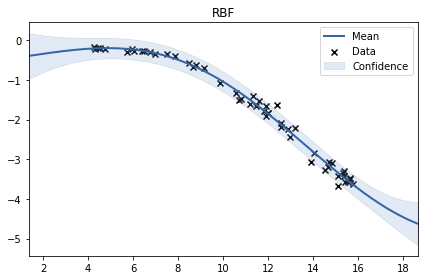

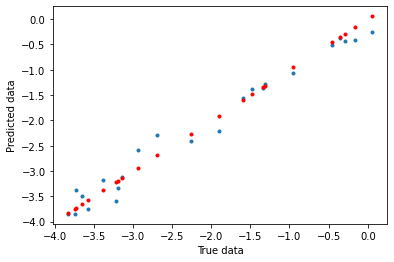

Cross-Predicted Accuracy for RBF : 0.9744831889431408
Mean absolute error for RBF : 0.16878775020072104
Mean squared error for RBF : 0.04408617193165578


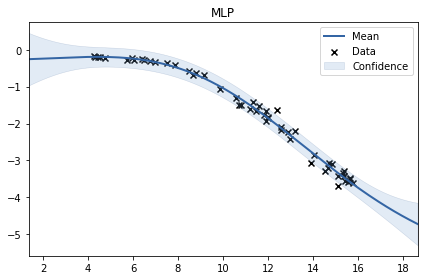

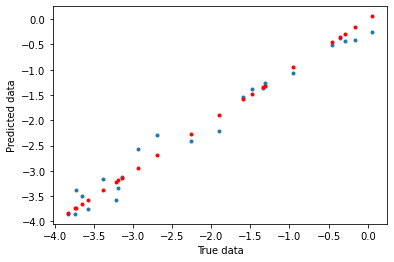

Cross-Predicted Accuracy for MLP : 0.9741897023936249
Mean absolute error for MLP : 0.17058351561472423
Mean squared error for MLP : 0.04459323758546168


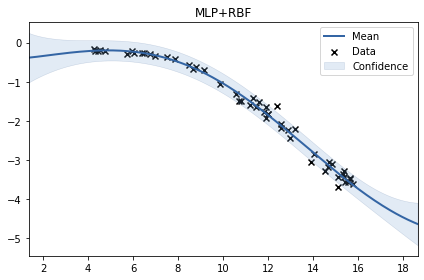

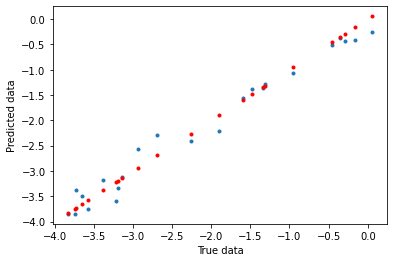

Cross-Predicted Accuracy for MLP+RBF : 0.9744522503305157
Mean absolute error for MLP+RBF : 0.1689762914156185
Mean squared error for MLP+RBF : 0.044139625515353005


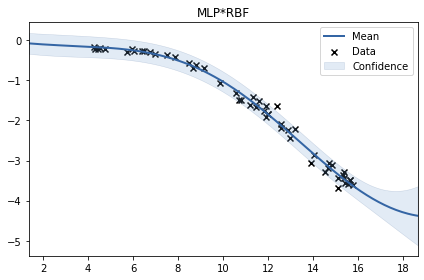

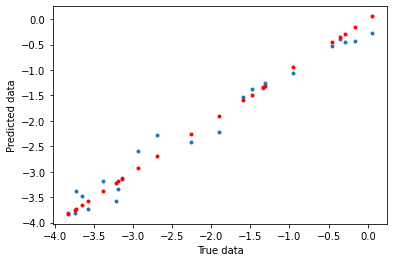

Cross-Predicted Accuracy for MLP*RBF : 0.9744668583272651
Mean absolute error for MLP*RBF : 0.16924042837545225
Mean squared error for MLP*RBF : 0.04411438683427983


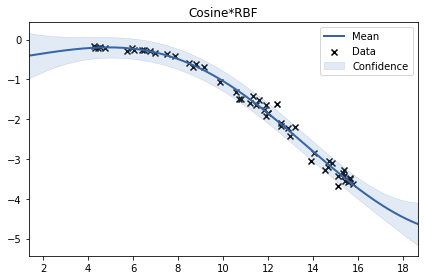

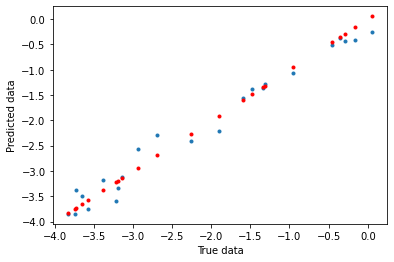

Cross-Predicted Accuracy for Cosine*RBF : 0.9744737019440499
Mean absolute error for Cosine*RBF : 0.1688432639424632
Mean squared error for Cosine*RBF : 0.04410256290904325


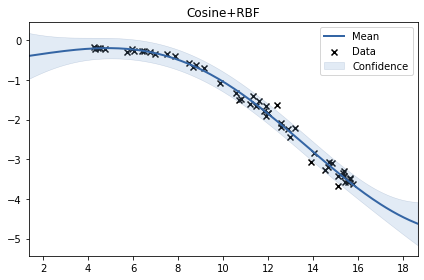

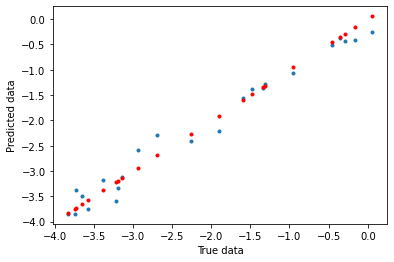

Cross-Predicted Accuracy for Cosine+RBF : 0.9744831897399703
Mean absolute error for Cosine+RBF : 0.1687877454244117
Mean squared error for Cosine+RBF : 0.04408617055494922
Cosine+RBF


In [16]:
from metab_utils import try_gp_regressions
mvl, kvl, resultsvl = try_gp_regressions(vl_1_rt_mod, zik_1_rt_mod-vl_1_rt_mod)

sum.,value,constraints,priors
rbf.variance,6.662094345571136,+ve,
rbf.lengthscale,9.878683724869141,+ve,
mlp.variance,1.1624268707693741,+ve,
mlp.weight_variance,395.8942392256604,+ve,
mlp.bias_variance,6.429068873504387e-154,+ve,


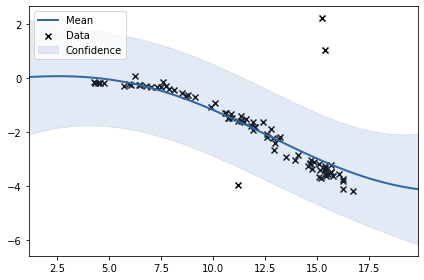

In [447]:
kvl = GPy.kern.RBF(input_dim=1, variance=0.1, lengthscale=6.5) + GPy.kern.MLP(1)
mvl = GPy.models.GPRegression(np.array(vl_1_rt)[:,None], np.array(zik_1_rt)[:,None]-np.array(vl_1_rt)[:,None], kvl)

mvl.optimize()
mvl.plot()
mvl.parameters[0]

(-1.0, 1.0)

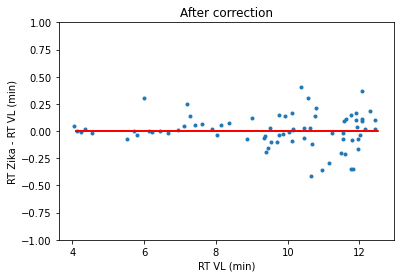

In [17]:
gpr_predicted_data,_ = mvl.predict(np.array(vl_1_rt_mod)[:,None])

plt.plot(np.array(vl_1_rt_mod)[:,None]+gpr_predicted_data, np.array(zik_1_rt_mod)[:,None] - (np.array(vl_1_rt_mod)[:,None]+gpr_predicted_data), '.')
plt.plot(np.array(zik_1_rt_mod)[:,None], np.array(zik_1_rt_mod)[:,None] -np.array(zik_1_rt_mod)[:,None], 'r')
plt.plot()
plt.xlabel('RT VL (min)')
plt.ylabel('RT Zika - RT VL (min)')
plt.title('After correction')
plt.ylim(-1,1)

In [ ]:
with open('/Users/anamaria/Documents/pymz/mzmine/vlmodel.txt', 'wb') as handle:
    pickle.dump(mvl, handle)

#### Zika RT vs HAT RT 

In [18]:
from metab_utils import get_rts_between_datasets
hat_1_rt, zik_1_rt, hat1_zik1_diff = get_rts_between_datasets('hat', 'zik', matches)

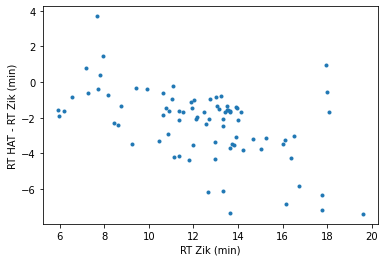

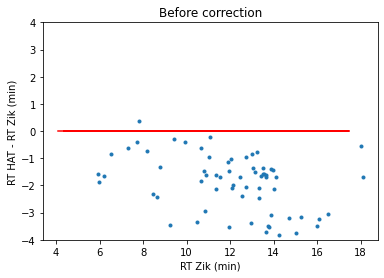

In [19]:
from metab_utils import plot_and_get_values_for_regression
zik_1_rt_mod, hat_1_rt_mod = plot_and_get_values_for_regression(zik_1_rt,'Zik',hat_1_rt,'HAT',  hat1_zik1_diff, ml=False)

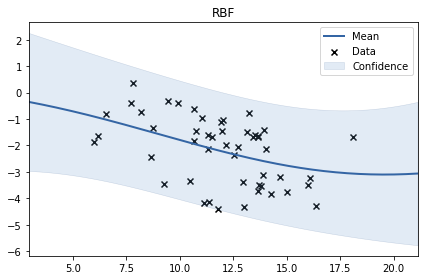

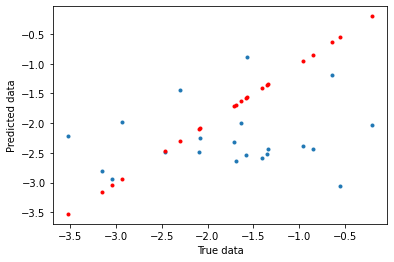

Cross-Predicted Accuracy for RBF : -0.5254394646234866
Mean absolute error for RBF : 0.9055650177617358
Mean squared error for RBF : 1.1829593404917491


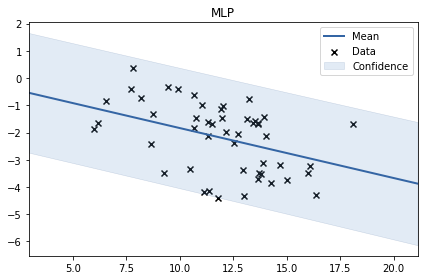

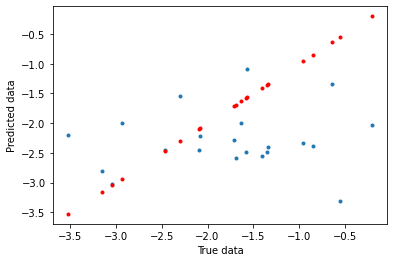

Cross-Predicted Accuracy for MLP : -0.5492657535539238
Mean absolute error for MLP : 0.8890249613687671
Mean squared error for MLP : 1.2014363313479368


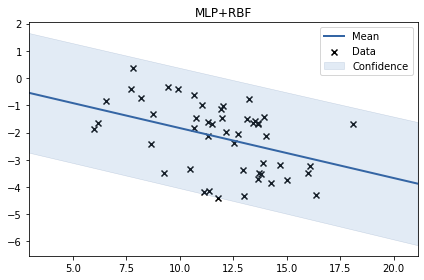

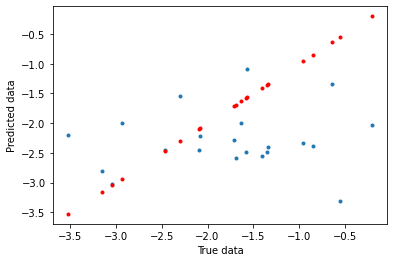

Cross-Predicted Accuracy for MLP+RBF : -0.5492952194581449
Mean absolute error for MLP+RBF : 0.8890335483766778
Mean squared error for MLP+RBF : 1.2014591817903388


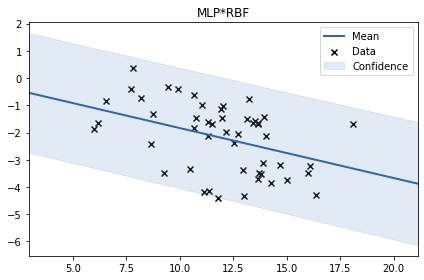

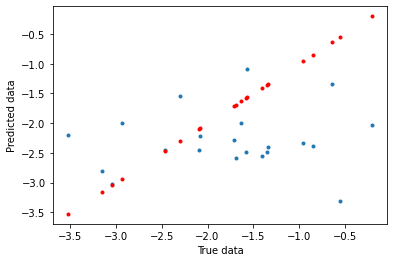

Cross-Predicted Accuracy for MLP*RBF : -0.549276928474254
Mean absolute error for MLP*RBF : 0.8890251172673177
Mean squared error for MLP*RBF : 1.2014449973597257


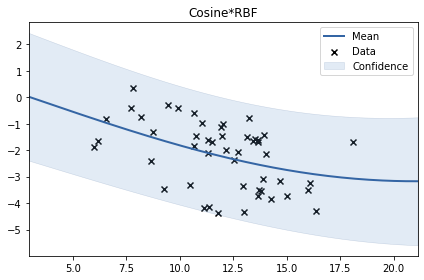

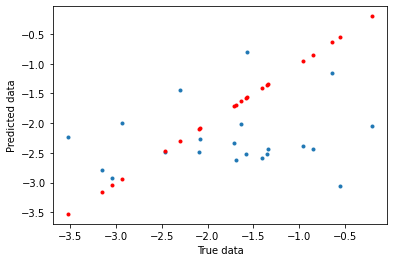

Cross-Predicted Accuracy for Cosine*RBF : -0.5335939579456805
Mean absolute error for Cosine*RBF : 0.9105423323950858
Mean squared error for Cosine*RBF : 1.189283048686127


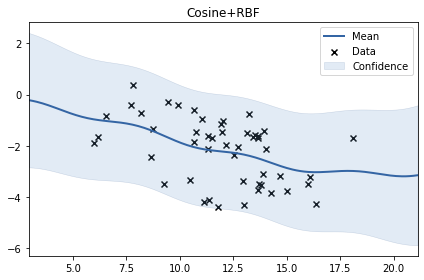

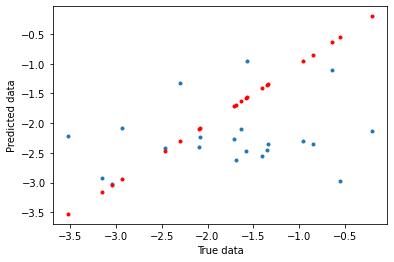

Cross-Predicted Accuracy for Cosine+RBF : -0.44269929464679936
Mean absolute error for Cosine+RBF : 0.8685338252817374
Mean squared error for Cosine+RBF : 1.1187953673038942
Cosine+RBF


In [20]:
from metab_utils import try_gp_regressions
mhat, khat, resultshat = try_gp_regressions(hat_1_rt_mod, zik_1_rt_mod-hat_1_rt_mod)

sum.,value,constraints,priors
Cosine.variance,0.07304756892138273,+ve,
Cosine.lengthscale,0.8254630507041266,+ve,
rbf.variance,3.3946601277425286,+ve,
rbf.lengthscale,10.74770878108617,+ve,


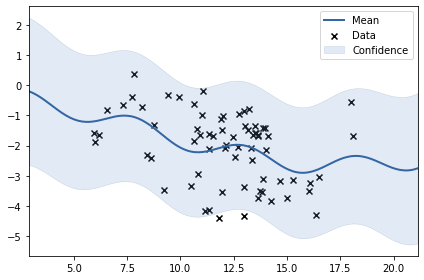

In [21]:
khat = khat
mhat = GPy.models.GPRegression(hat_1_rt_mod[:,None], zik_1_rt_mod[:,None]-hat_1_rt_mod[:,None], khat)

mhat.optimize()
mhat.plot()
mhat.parameters[0]

(-4.0, 4.0)

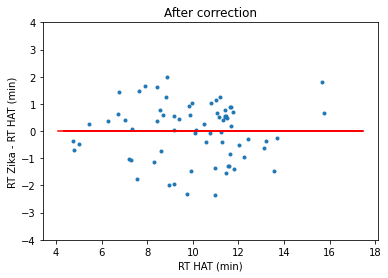

In [22]:
gpr_predicted_data,_ = mhat.predict(np.array(hat_1_rt_mod)[:,None])

plt.plot(np.array(hat_1_rt_mod)[:,None]+gpr_predicted_data, np.array(zik_1_rt_mod)[:,None] - (np.array(hat_1_rt_mod)[:,None]+gpr_predicted_data), '.')
plt.plot(np.array(zik_1_rt_mod)[:,None], np.array(zik_1_rt_mod)[:,None] -np.array(zik_1_rt_mod)[:,None], 'r')
plt.plot()
plt.xlabel('RT HAT (min)')
plt.ylabel('RT Zika - RT HAT (min)')
plt.title('After correction')
plt.ylim(-4,4)

In [47]:
with open('/Users/anamaria/Documents/pymz/mzmine/hatmodel.txt', 'wb') as handle:
    pickle.dump(mhat, handle)

### Binning based on m/z data

In [26]:
from metab_utils import plot_gpr_bins_mz_range
from metab_utils import plot_gpr_bins_same_width

Bin: 0 
m/z range: (76.03929138183594, 137.85718994140626)
  rbf.         |                value  |  constraints  |  priors
  variance     |  0.10924062340234678  |      +ve      |        
  lengthscale  |   23.559339614344193  |      +ve      |        
Bin: 1 
m/z range: (137.85718994140626, 199.67508850097656)
  rbf.         |                value  |  constraints  |  priors
  variance     |  0.06774246486507138  |      +ve      |        
  lengthscale  |     7.79574824792595  |      +ve      |        
Bin: 2 
m/z range: (199.67508850097656, 261.49298706054685)
  rbf.         |                value  |  constraints  |  priors
  variance     |  0.14320494930388594  |      +ve      |        
  lengthscale  |   21.037790271030378  |      +ve      |        
Bin: 3 
m/z range: (261.49298706054685, 323.3108856201172)
  rbf.         |                value  |  constraints  |  priors
  variance     |  0.08736176862385243  |      +ve      |        
  lengthscale  |    1386.118589014714  |      +

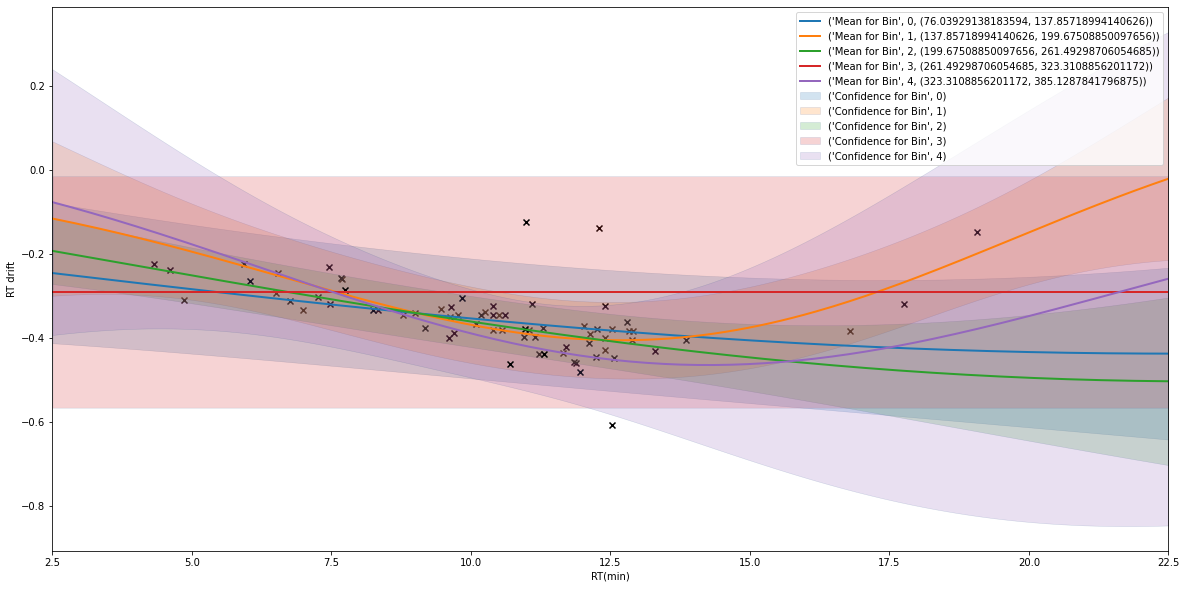

In [44]:
plot_gpr_bins_mz_range(5, 'mal', 'zik', matches, False, 0.5)

Bin: 0 
m/z range: 76.03929138183594 , 123.05532836914062
  rbf.         |                value  |  constraints  |  priors
  variance     |  0.12013803354272005  |      +ve      |        
  lengthscale  |     665.760367800072  |      +ve      |        
Bin: 1 
m/z range: 124.03933715820312 , 134.0447769165039
  rbf.         |                value  |  constraints  |  priors
  variance     |  0.12826006757953887  |      +ve      |        
  lengthscale  |    652.7076668605157  |      +ve      |        
Bin: 2 
m/z range: 136.04273986816406 , 167.03872680664062
  rbf.         |                value  |  constraints  |  priors
  variance     |  0.06977105746874958  |      +ve      |        
  lengthscale  |    8.837883756386539  |      +ve      |        
Bin: 3 
m/z range: 168.06561279296875 , 206.06683349609375
  rbf.         |                value  |  constraints  |  priors
  variance     |  0.05598436345280817  |      +ve      |        
  lengthscale  |    6.799061526045808  |      +ve  

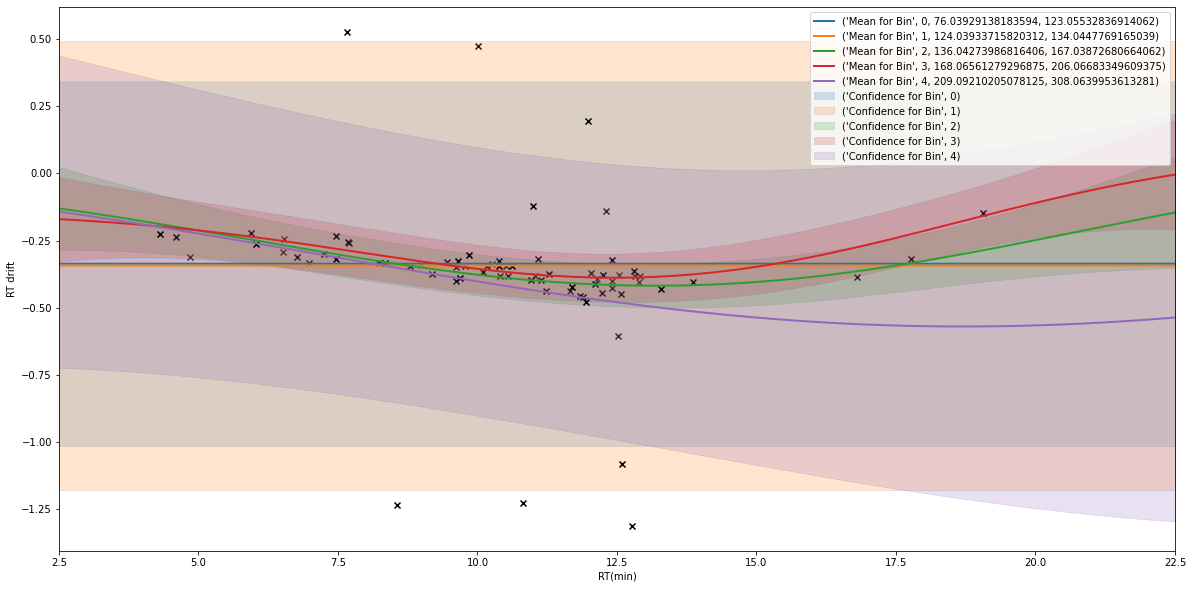

In [45]:
plot_gpr_bins_same_width(5, 'mal', 'zik', matches, False, 1.4)

Bin: 0 
m/z range: 76.03929138183594 , 120.0655746459961
  rbf.         |               value  |  constraints  |  priors
  variance     |  10.212597206727503  |      +ve      |        
  lengthscale  |   9.717449777941974  |      +ve      |        
Bin: 1 
m/z range: 123.05521392822266 , 136.042724609375
  rbf.         |               value  |  constraints  |  priors
  variance     |   8.552531710697101  |      +ve      |        
  lengthscale  |  10.108411986067559  |      +ve      |        
Bin: 2 
m/z range: 136.0618133544922 , 175.10779571533203
  rbf.         |               value  |  constraints  |  priors
  variance     |  10.704416491823642  |      +ve      |        
  lengthscale  |   7.718824080148981  |      +ve      |        
Bin: 3 
m/z range: 176.1029510498047 , 209.09214782714844
  rbf.         |               value  |  constraints  |  priors
  variance     |  13.140208507189504  |      +ve      |        
  lengthscale  |   10.46837339759746  |      +ve      |        
Bi

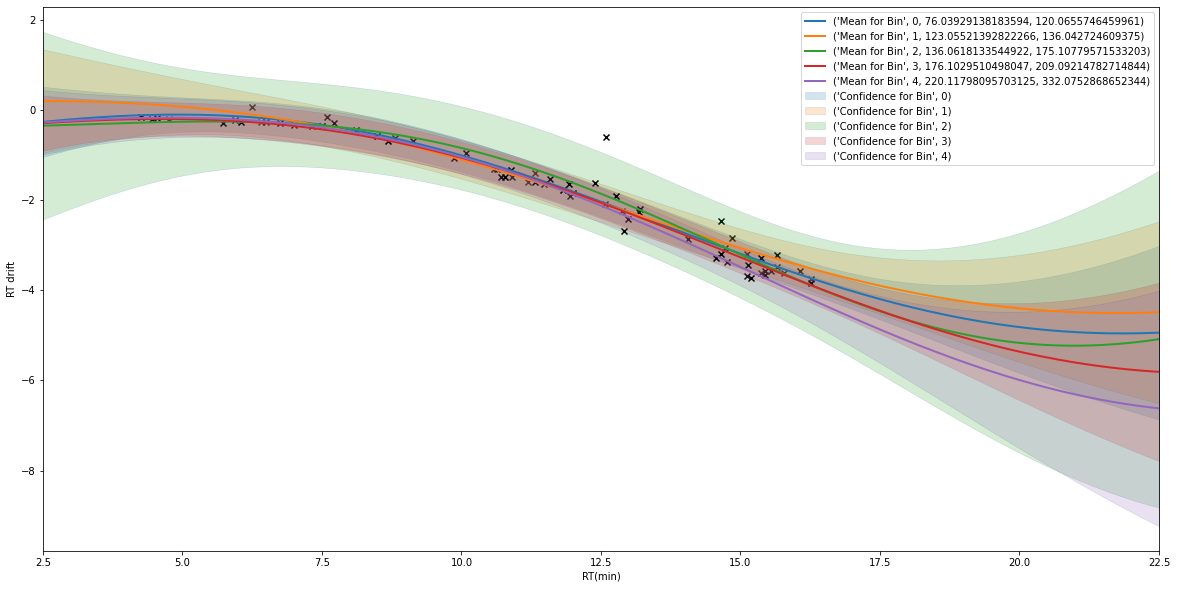

In [46]:
plot_gpr_bins_same_width(5, 'vl', 'zik', matches, False, 1.4)